# Time Series Forecast

Problem:
The dataset is composed of power consumption data. From here, we want to predict energy consumption in the trend of hours. We would like to create a time series model to predict energy consumption.

In [339]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
import collections
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,LSTM,GRU
from keras.utils.np_utils import to_categorical
from keras import initializers, regularizers, constraints
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [309]:
df=pd.read_csv('pjm_hourly_est.csv')
#pjm_load=pd.read_csv('PJM_Load_hourly.csv')

In [310]:
df.isna().sum()/df.shape[0]

Datetime    0.000000
AEP         0.319692
COMED       0.626970
DAYTON      0.319681
DEOK        0.676100
DOM         0.348212
DUQ         0.332062
EKPC        0.745689
FE          0.647294
NI          0.672112
PJME        0.184537
PJMW        0.196654
PJM_Load    0.815463
dtype: float64

Understand type of data

In [311]:
df.dtypes

Datetime     object
AEP         float64
COMED       float64
DAYTON      float64
DEOK        float64
DOM         float64
DUQ         float64
EKPC        float64
FE          float64
NI          float64
PJME        float64
PJMW        float64
PJM_Load    float64
dtype: object

 PJME is choose, becauase less mising value and missing value is in first few date.

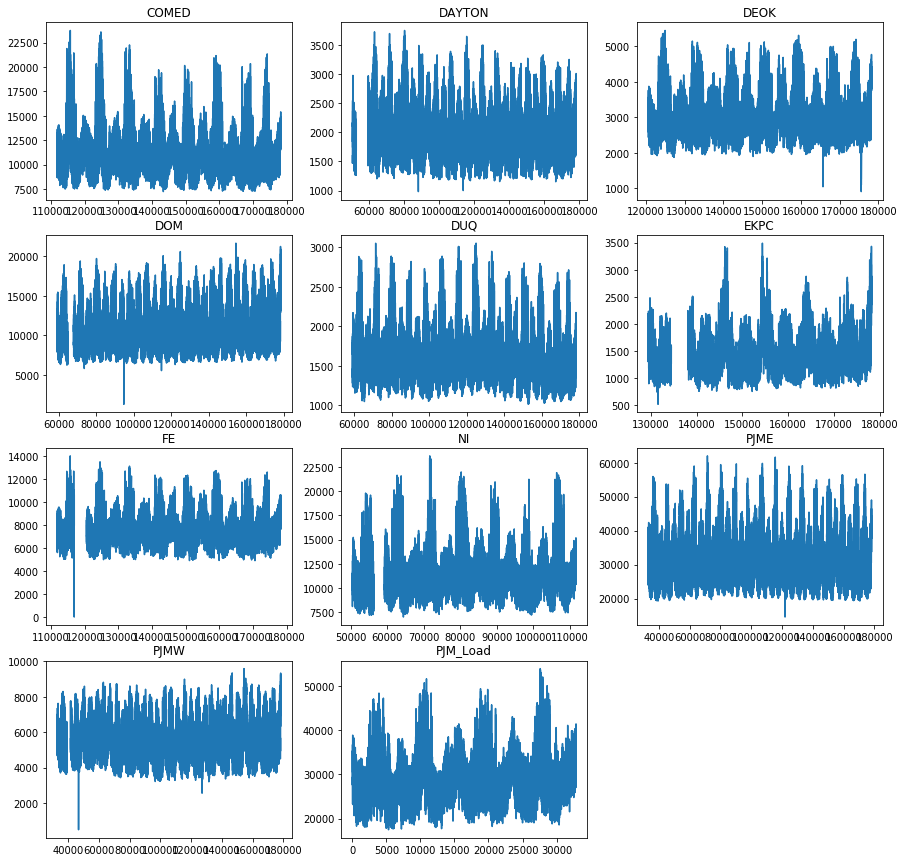

In [290]:
plt.figure(figsize=(15,15))
j=0
for i in df.columns[2:]:
    j+=1
    plt.subplot(4,3,j)
    plt.plot(df[i])
    plt.title(i)

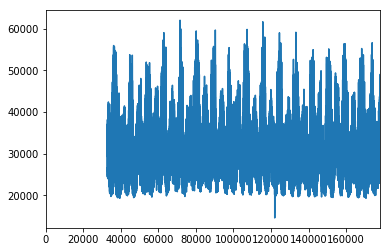

In [338]:
df['PJME'].plot()

In [332]:
pjme=df[['Datetime','PJME']]
pjme['Datetime'] = pd.to_datetime(pjme['Datetime'])
pjme['hour']=pd.to_datetime(pjme['Datetime']).dt.hour
pjme['month']=pd.to_datetime(pjme['Datetime']).dt.month
pjme['day']=pd.to_datetime(pjme['Datetime']).dt.day
print ('Unique values of month:',pjme.month.unique())
print ('Unique values of hour:',pjme.hour.unique())
pjme['hr_sin'] = np.sin(pjme.hour*(2.*np.pi/24))
pjme['hr_cos'] = np.cos(pjme.hour*(2.*np.pi/24))
pjme['mnth_sin'] = np.sin((pjme.month-1)*(2.*np.pi/12))
pjme['mnth_cos'] = np.cos((pjme.month-1)*(2.*np.pi/12))
pjme['day_sin'] = np.sin(pjme.day*(2.*np.pi/24))
pjme['day_cos'] = np.cos(pjme.day*(2.*np.pi/24))
pjme=pjme.sort_values(by='Datetime')
pjme=pjme.set_index(['Datetime'])
pjme=pjme[pjme.index>'2002-01-01 01:00:00']
pjme.dropna(inplace=True)

Unique values of month: [12  1 11 10  9  8  7  6  5  4  3  2]
Unique values of hour: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0]


In [333]:
pjme.columns

Index(['PJME', 'hour', 'month', 'day', 'hr_sin', 'hr_cos', 'mnth_sin',
       'mnth_cos', 'day_sin', 'day_cos'],
      dtype='object')

# hour is highly correlated to PJME

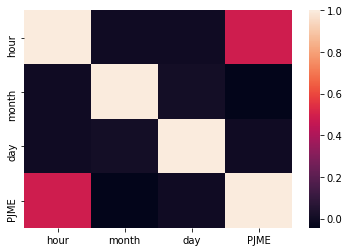

In [336]:
sns.heatmap(pjme[['hour', 'month', 'day','PJME']].corr())

HOUR, DAY, HOUR IS NORMALIZE BY COS SIN

<Figure size 432x288 with 0 Axes>

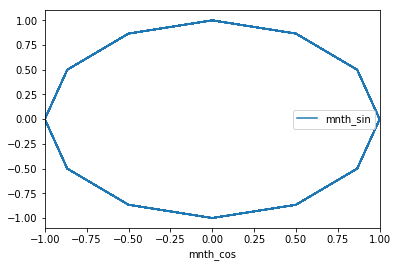

<Figure size 432x288 with 0 Axes>

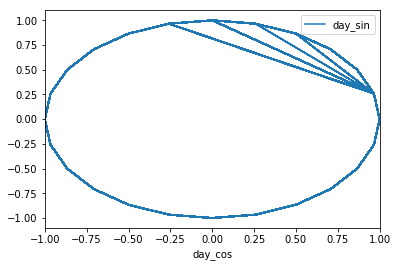

<Figure size 432x288 with 0 Axes>

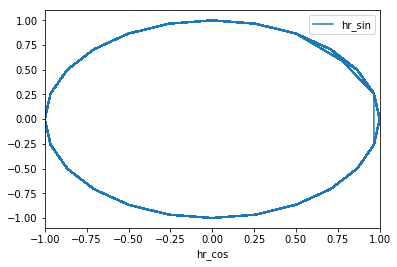

In [21]:
plt.figure()
pjme.plot(x='mnth_cos',y='mnth_sin')
plt.figure()
pjme.plot(x='day_cos',y='day_sin')
plt.figure()
pjme.plot(x='hr_cos',y='hr_sin')

since hour is correlated, plot hour cos sin versus pjme, we see a trend in 3D chart

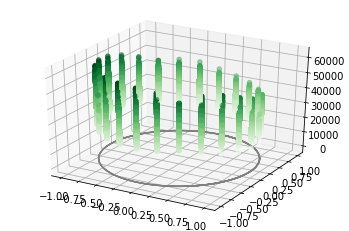

In [337]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
ax.scatter3D(pjme['hr_cos'], pjme['hr_sin'], pjme['PJME'],c=pjme['PJME'],cmap='Greens');

a boxplot for hour month day is plot. More energy consume at afternoon and morning is lesses. 

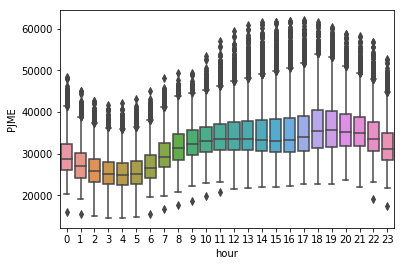

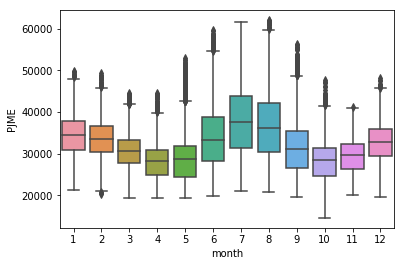

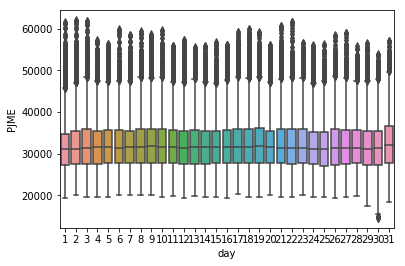

In [42]:
import seaborn as sns
sns.boxplot(x=pjme.hour,y=pjme.PJME)
plt.figure()
sns.boxplot(x=pjme.month,y=pjme.PJME)
plt.figure()
sns.boxplot(x=pjme.day,y=pjme.PJME)

# check if missing value still exist

In [62]:
pjme.isna().sum()

Datetime    0
PJME        0
hour        0
month       0
hr_sin      0
hr_cos      0
mnth_sin    0
mnth_cos    0
dtype: int64

In [52]:
import warnings
warnings.filterwarnings("ignore")

# standardize PJME

In [241]:
mini=pjme['PJME'].min()
maxi=pjme['PJME'].max()

- trainform data to train and test
- convert the shape of feature by consider time step, 5 time step is using

In [345]:
#print(pjme.Datetime.min())
#print(pjme.Datetime.max())
pjme['std_PJME']=(pjme['PJME']-mini)/(maxi-mini)
features = ['mnth_sin','mnth_cos','hr_sin','hr_cos','std_PJME']
#features = ['PJME']
X=pjme[features]
scaler = MinMaxScaler()
cols, names =list(),list()
start_time=0
last_time=5
time=last_time-start_time
for i in range(start_time,last_time+1):
    cols.append(X.shift(i))
    names += [('%s(t-%d)' % (X.columns[j], i)) for j in range(X.shape[1])]
agg = pd.concat(cols, axis=1)
agg.columns = names
drop_col=[]
for i in agg.columns:
    if 't-0' in i:
        drop_col.append(i)
train=agg[(agg.index>'2005-01-01 00:00:00')&(agg.index<'2012-01-01 00:00:00')]
X_train =train.drop(drop_col,axis=1)
X_train = np.array(X_train).reshape((X_train.shape[0],time,int(X_train.shape[1]/(time))))
y_train=np.array(train['std_PJME(t-0)'])
test=agg[(agg.index>='2012-01-01 00:00:00')]
X_test =test.drop(drop_col,axis=1)
X_test = np.array(X_test).reshape(( X_test.shape[0],time,int(X_test.shape[1]/(time))))
y_test=np.array(test['std_PJME(t-0)'])

# modelling with GRU

Train on 61328 samples, validate on 57740 samples
Epoch 1/100
61328/61328 [==============================] - 58s 942us/step - loss: 0.0065 - val_loss: 8.7668e-04
Epoch 2/100
61328/61328 [==============================] - 22s 351us/step - loss: 0.0017 - val_loss: 6.7184e-04
Epoch 3/100
61328/61328 [==============================] - 21s 349us/step - loss: 0.0012 - val_loss: 5.6688e-04
Epoch 4/100
61328/61328 [==============================] - 20s 330us/step - loss: 0.0010 - val_loss: 4.6385e-04
Epoch 5/100
61328/61328 [==============================] - 22s 364us/step - loss: 8.4859e-04 - val_loss: 5.4909e-04
Epoch 6/100
61328/61328 [==============================] - 22s 358us/step - loss: 7.3085e-04 - val_loss: 3.8987e-04
Epoch 7/100
61328/61328 [==============================] - 22s 351us/step - loss: 6.5303e-04 - val_loss: 4.3394e-04
Epoch 8/100
61328/61328 [==============================] - 23s 380us/step - loss: 5.8771e-04 - val_loss: 3.9781e-04
Epoch 9/100
61328/61328 [=============

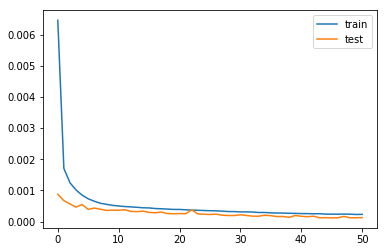

In [347]:

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint('../model3.h5', save_best_only=True,save_weights_only=False)]
model = Sequential()
    
model.add(GRU(16, return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(32, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')
    

# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
history = model.fit(X_train, y_train, callbacks=callbacks,
                            epochs=100, batch_size=100,
                   validation_data=(X_test, y_test))
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model = load_model('../model3.h5')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

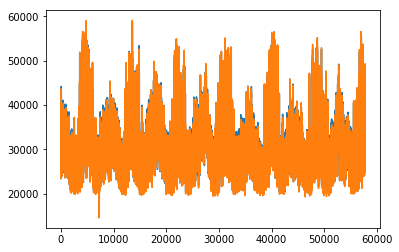

In [349]:
yhat = model.predict(X_test)*(maxi-mini)+mini
actual_y=y_test*(maxi-mini)+mini
plt.plot(yhat)
plt.plot(actual_y)

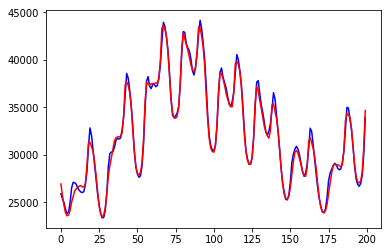

In [351]:
plt.plot(yhat[:200],color='Blue')
plt.plot(actual_y[:200],color='Red')

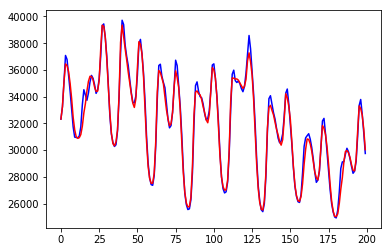

In [352]:
plt.plot(yhat[1000:1200],color='Blue')
plt.plot(actual_y[1000:1200],color='Red')